# 注意力评分函数

## 1 导入相关库

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### 1.1 定义热度图函数

In [ ]:
def plot_hotmap(harvest, x_label = None, y_lable = None, hotmap_value = False, rotate_x_text = False, txt = False):
    # 生成图形对象 fig 和 子图对象 ax，使用约束布局避免重叠
    fig, ax = plt.subplots(constrained_layout=True)
    # 设置坐标轴比例
    ax.set_aspect(aspect=1.0)
    # 设置坐标轴范围，更多参数 https://www.wolai.com/matplotlib/9S3VvdWev3tNckFvKcMHKA
    im = ax.imshow(harvest, cmap="Reds")
    # # X轴 和 Y轴 上的标签文字
    # ax.set_xticks(np.arange(len(x_ax_text)), labels=x_ax_text)
    # ax.set_yticks(np.arange(len(y_ax_text)), labels=y_ax_text)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_lable)
    # 添加文字注释
    if txt == True:
        harvest = harvest.squeeze()
        # m是行，n是列
        m, n = harvest.shape[-2], harvest.shape[-1]
        print(m, n)
        if hotmap_value:
            for i in range(m):
                for j in range(n):
                    text = ax.text(j, i, harvest.squeeze()[i, j], ha="center", va="center", color="black")
    # 旋转X轴标签文字
    if rotate_x_text:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # 添加颜色条
    cbar = fig.colorbar(im, ax=ax, shrink=0.92, aspect=15)
    # 设置颜色条标签
    cbar.set_label("attention value (unit)", fontweight="bold")
    # 保存图片
    # plt.savefig('./热度图.png', dpi=300)
    # 显示图片
    plt.show()

## 2 Additive评分函数
$$
\begin{align}
a(q, k) = W^Ttanh(W_{q}q + W_{k}k) \in R
\end{align}
$$
官方是用全连接层来得到q、k和v，但是用一个矩阵应该也行。输入是（批量，几个token，每个token的长度）。在这里我们和官方一样也用全连接层而不用单设一个矩阵。
因为全连接层就是可以当作一个矩阵乘法。q与k的维度是一样的。v的维度可以自己指定。  
$nn中的神经网络函数都是一行一行输入的$

In [1]:
class Additive_Attention_score(nn.Module):
    def __init__(self, token_size, qk_size, v_size):
        super().__init__()
        self.W_q = nn.Linear(token_size, qk_size)
        self.W_k = nn.Linear(token_size, qk_size)
        self.W_v = nn.Linear(token_size, v_size)
        self.W = nn.Linear(qk_size, 1)

    def forward(self, x):
        q = self.W_q(x)
        k = self.W_k(x)
        output = torch.tanh(q + k)

        return self.W(output)

NameError: name 'nn' is not defined

In [ ]:
x = torch.rand((3, 3, 3))
additive = Additive_Attention_score(x.shape[2], x.shape[2], 1)
a = additive(x)
a

tensor([[[-0.1704],
         [-0.1921],
         [-0.1683]],

        [[-0.1241],
         [-0.1178],
         [-0.1111]],

        [[-0.2144],
         [-0.1745],
         [-0.1672]]], grad_fn=<ViewBackward0>)

3 3


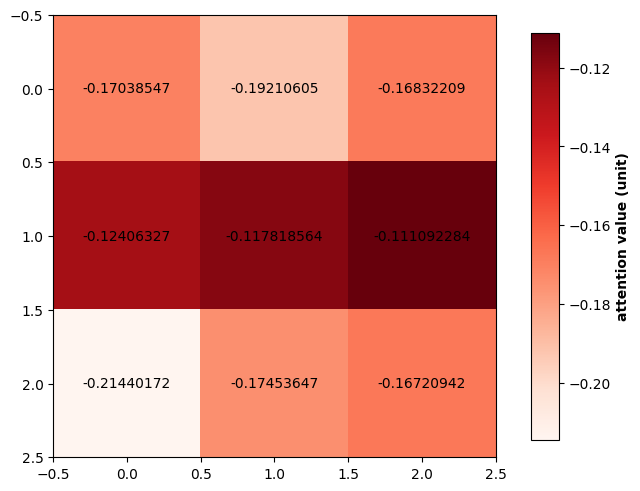

In [ ]:
plot_hotmap(a.detach().numpy(), hotmap_value=True, txt=True)

## 3 Dot-product评分函数
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)
$$
其中d为每个q和k的长度。self-attention中输入与输出的长度是一样的，所以在单头的self-attention中v的长度就是b的长度
因为b是由v乘注意力分数，而注意力分数是一个标量。

In [ ]:
class Dotproduct_Attention_score(nn.Module):
    def __init__(self, token_size, qk_size, v_size):
        super().__init__()
        self.scale = qk_size ** -0.5
        self.W_q = nn.Linear(token_size, qk_size)
        self.W_k = nn.Linear(token_size, qk_size)
        self.W_v = nn.Linear(token_size, v_size)

    def forward(self, x):
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)
        output = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        output = output.sum(dim = -1)
        output = torch.softmax(output, dim = -1)

        return output

In [7]:
x = torch.rand((2, 2, 3))
additive = Dotproduct_Attention_score(x.shape[2], x.shape[2], 1)
b = additive(x)
b

tensor([[0.5303, 0.4697],
        [0.4552, 0.5448]], grad_fn=<SoftmaxBackward0>)

2 2


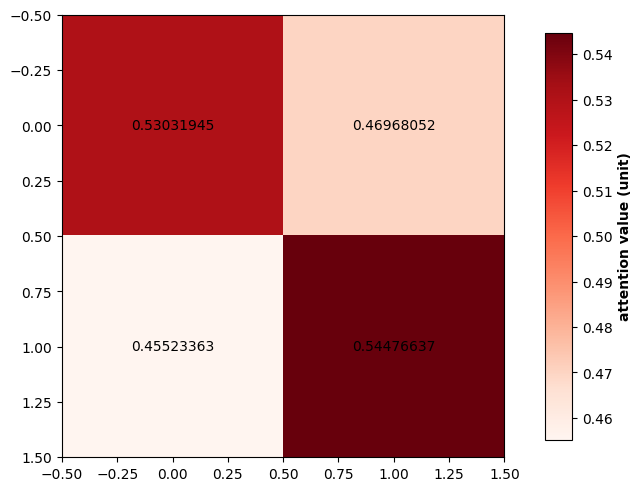

In [8]:
plot_hotmap(b.detach().numpy(), hotmap_value=True, txt=True)